# Introduction

In [1]:
import numpy as np
import pandas as pd 

import os
import time

from contextlib import contextmanager

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
@contextmanager
def timer(title, p = 3) :
    start_time = time.time()
    yield
    duration = round(time.time() - start_time, p)
    print(title, ":", duration, "seconde(s)")

In [3]:
print("--- FICHIERS CSV ---")
csv_files = [file for file in os.listdir("csv/") if file.endswith(".csv")]
for file in csv_files :
    print(file)

--- FICHIERS CSV ---
application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv


Les fichiers `application_test.csv` et `sample_submission.csv` servent à la compétition Kaggle d'où les données sont extraites.<br>
Le premier est un jeu de validation qui ne contient pas la colonne `TARGET` des étiquettes.<br>
Le second est un exemple de soumission pour la compétition.<br>
Ces deux fichiers ne seront d'aucune utilité pour le projet qui nous occupe.

Le fichier `HomeCredit_columns_description.csv` contient quant à lui les informations sur les colonnes de chaque table.<br>
Il peut nous aider à comprendre les données, mais ne sera pas utilisé par les modèles.

In [4]:
columns_descriptions = pd.read_csv("csv/HomeCredit_columns_description.csv", encoding = "ISO-8859-1")
print("Dimensions :", columns_descriptions.shape)
columns_descriptions.sample(5)

Dimensions : (219, 5)


,Unnamed: 0,Table,Row,Description,Special
10,13,application_{train|test}.csv,AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
110,113,application_{train|test}.csv,FLAG_DOCUMENT_16,Did client provide document 16,NaN
52,55,application_{train|test}.csv,FLOORSMIN_AVG,Normalized information about building where th...,normalized
32,35,application_{train|test}.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,NaN


On pourra utiliser la fonction suivante pour afficher les informations d'une colonne donnée.

In [5]:
def display_description(column, table, descriptions) :
    
    if table == "application_train" :
        file = "application_{train|test}.csv"
    elif table == "pos_cash_balance" :
        file = "POS_CASH_balance.csv"
    else :
        file = table + ".csv"
    
    row = descriptions[(descriptions["Table"] == file) & (descriptions["Row"] == column)]
    
    if len(row) == 0 :
        print("La colonne", column, "n'existe pas.")
    else :
        print("Colonne :", column)
        print("Table :", table + ".csv")
        if pd.notnull(row["Special"].iloc[0]) :
            print("Format :", row["Special"].iloc[0])
        print("\nDescription :")
        print(row["Description"].iloc[0])

In [6]:
display_description("NAME_YIELD_GROUP", "previous_application", columns_descriptions)

Colonne : NAME_YIELD_GROUP
Table : previous_application.csv
Format : grouped

Description :
Grouped interest rate into small medium and high of the previous application


Il nous reste donc sept tables restantes, qui s'organisent selon la structure suivante.

<div style="font-weight: bold; font-size: 20px; margin-left:15%;">Schéma de l'agencement des tables</div>

<img src="data_structure.jpg" alt="Structure des données" style="float:left; width:75%">

Chargeons ces sept tables dans des dataframes et affichons leurs dimensions.

In [7]:
files_to_exclude = ["HomeCredit_columns_description.csv",
                    "application_test.csv",
                    "sample_submission.csv"]

data_files = [file for file in csv_files if file not in files_to_exclude]

with timer("\nTemps de chargement") :
    print("   --- Table ---\t--- Dimensions ---")
    for file in data_files :
        df = pd.read_csv("csv/" + file)
        name = file[:-4].lower()
        print(name.ljust(25), df.shape)
        globals()[name] = df

   --- Table ---	--- Dimensions ---
application_train         (307511, 122)
bureau                    (1716428, 17)
bureau_balance            (27299925, 3)
credit_card_balance       (3840312, 23)
installments_payments     (13605401, 8)
pos_cash_balance          (10001358, 8)
previous_application      (1670214, 37)

Temps de chargement : 27.281 seconde(s)


EXPLIQUER LA STRATEGIE D'AGREGATION ICI

Terminons cette introduction avec quelques fonctions utilitaires :
- `missing_values_table` pour afficher les valeurs manquantes par colonne dans l'ordre décroissant des pourcentages.
- `display_infos` pour afficher diverses informations sur une table (échantillon, valeurs manquantes, types, détails sur variables catégorielles).
- `onehot_encoder` pour appliquer un encodage one-hot aux variables catégorielles d'un dataframe.

In [8]:
def missing_values_table(df, p = 3) :

    count = df.isnull().sum()
    percentage = 100 * df.isnull().sum() / len(df)
        
    table = pd.concat([count, percentage], axis = 1)
    table = table.rename(columns = {0 : "Missing Values", 1 : "Percentage"})
    table = table.loc[table["Missing Values"] != 0]
    table = table.sort_values("Percentage", ascending = False).round(p)

    print("Valeurs manquantes dans", len(table), "des", df.shape[1], "colonnes.")
    
    return table

In [9]:
def display_infos(df, sample_size = 5, missing_size = 10) :
    
    # Affichage d'un échantillon
    display(df.sample(sample_size))
    print()
    
    # Affichage des valeurs manquantes
    missing_table = missing_values_table(df)
    if not missing_table.empty :
        display(missing_table.head(missing_size))
    
    # Affichage des types de variables
    print("\nNombre de variables par type :")
    print(df.dtypes.value_counts().to_string())
    
    # Affichage des valeurs de chaque variable catégorielle
    categorical_columns = df.select_dtypes("object")
    for column in categorical_columns :
        print("\n" + column + " (" + str(df[column].nunique()) + " valeurs) :")
        print(list(df[column].unique()))

In [10]:
def onehot_encoder(df, with_na = False) :
    
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df_encoded = pd.get_dummies(df, columns = categorical_columns, dummy_na = with_na)
    new_columns = [col for col in df_encoded.columns if col not in df.columns]
    
    return df_encoded, new_columns

# Table `credit_card_balance`

In [11]:
display_infos(credit_card_balance)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
878139,1156213,317950,-79,120296.115,135000,0.0,0.0,0.0,0.0,6750.0,...,120296.115,120296.115,0.0,0,0.0,0.0,4.0,Active,0,0
1324575,1475071,364385,-44,46840.455,135000,0.0,0.0,0.0,0.0,6750.0,...,46840.455,46840.455,0.0,0,0.0,0.0,54.0,Active,0,0
3449410,2199014,255768,-5,0.000,427500,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,17.0,Active,0,0
3537842,2803413,240876,-14,0.000,45000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,50.0,Active,0,0
519926,1975774,123904,-82,0.000,67500,NaN,0.0,NaN,NaN,NaN,...,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0



Valeurs manquantes dans 9 des 23 colonnes.


,Missing Values,Percentage
AMT_PAYMENT_CURRENT,767988,19.998
AMT_DRAWINGS_ATM_CURRENT,749816,19.525
AMT_DRAWINGS_OTHER_CURRENT,749816,19.525
AMT_DRAWINGS_POS_CURRENT,749816,19.525
CNT_DRAWINGS_ATM_CURRENT,749816,19.525
CNT_DRAWINGS_OTHER_CURRENT,749816,19.525
CNT_DRAWINGS_POS_CURRENT,749816,19.525
AMT_INST_MIN_REGULARITY,305236,7.948
CNT_INSTALMENT_MATURE_CUM,305236,7.948



Nombre de variables par type :
float64    15
int64       7
object      1

NAME_CONTRACT_STATUS (7 valeurs) :
['Active', 'Completed', 'Demand', 'Signed', 'Sent proposal', 'Refused', 'Approved']


In [12]:
def process_credit_card_balance(credit_card_balance) :
    
    # Encodage one-hot des variables catégorielles
    df = credit_card_balance.copy()
    df["NAME_CONTRACT_STATUS"] = df["NAME_CONTRACT_STATUS"].str.upper().str.replace(" ", "_")
    df, onehot_columns = onehot_encoder(df)

    # Agrégation par client
    df.drop(["SK_ID_PREV"], axis = 1, inplace = True)
    df_agg = df.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    df_agg.columns = pd.Index(["CARD_" + col[0] + "_" + col[1].upper() for col in df_agg.columns])
    
    # Ajout du nombre de lignes par client
    df_agg["CARD_COUNT"] = df.groupby("SK_ID_CURR").size()

    return df_agg

In [13]:
with timer("Temps de traitement") :
    credit_card_balance_processed = process_credit_card_balance(credit_card_balance)

print("Dimensions initiales :", credit_card_balance.shape)
print("Nouvelles dimensions :", credit_card_balance_processed.shape)

Temps de traitement : 7.534 seconde(s)
Dimensions initiales : (3840312, 23)
Nouvelles dimensions : (103558, 136)


# Table `installments_payments`

In [14]:
display_infos(installments_payments)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
11265739,2099828,360270,1.0,7,-110.0,-117.0,20876.805,20876.805
2287797,1009459,166630,1.0,6,-566.0,-574.0,12806.910,12806.910
5499225,2011869,291326,0.0,107,-50.0,-50.0,264.240,264.240
11502248,1776340,448027,1.0,11,-638.0,-645.0,9177.570,9177.570
7487070,2495203,278476,2.0,16,-33.0,-62.0,25549.380,91048.500



Valeurs manquantes dans 2 des 8 colonnes.


,Missing Values,Percentage
DAYS_ENTRY_PAYMENT,2905,0.021
AMT_PAYMENT,2905,0.021



Nombre de variables par type :
float64    5
int64      3


In [15]:
def process_installments_payments(installments_payments) :
    
    df = installments_payments.copy()
    
    # Paiement par versement : ajout du ratio et du reste
    df["PAYMENT_PERC"] = df["AMT_PAYMENT"] / df["AMT_INSTALMENT"]
    df["PAYMENT_DIFF"] = df["AMT_INSTALMENT"] - df["AMT_PAYMENT"]

    # Ajout du nombre de jours entre paiement et versement sans valeur négative
    df["DPD"] = df["DAYS_ENTRY_PAYMENT"] - df["DAYS_INSTALMENT"]
    df["DBD"] = df["DAYS_INSTALMENT"] - df["DAYS_ENTRY_PAYMENT"]
    df["DPD"] = df["DPD"].apply(lambda x : x if x > 0 else 0)
    df["DBD"] = df["DBD"].apply(lambda x : x if x > 0 else 0)
   
    # Fonctions d'agrégation
    agg_fct = {
        "NUM_INSTALMENT_VERSION" : ["nunique"],
        "DPD" : ["max", "mean", "sum"],
        "DBD" : ["max", "mean", "sum"],
        "PAYMENT_PERC" : ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF" : ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT" : ["max", "mean", "sum"],
        "AMT_PAYMENT" : ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT" : ["max", "mean", "sum"]
    }

    # Agrégation par client
    df_agg = df.groupby("SK_ID_CURR").agg(agg_fct)
    df_agg.columns = pd.Index(["INSTAL_" + col[0] + "_" + col[1].upper() for col in df_agg.columns])
    
    # Ajout du nombre de lignes par client
    df_agg["INSTAL_COUNT"] = df.groupby("SK_ID_CURR").size()

    return df_agg

In [16]:
with timer("Temps de traitement") :
    installments_payments_processed = process_installments_payments(installments_payments)

print("Dimensions initiales :", installments_payments.shape)
print("Nouvelles dimensions :", installments_payments_processed.shape)

Temps de traitement : 18.179 seconde(s)
Dimensions initiales : (13605401, 8)
Nouvelles dimensions : (339587, 26)


# Table `pos_cash_balance`

In [17]:
display_infos(pos_cash_balance)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
7423655,1565180,249787,-5,12.0,2.0,Active,0,0
2331928,1853181,342353,-6,12.0,3.0,Active,0,0
5790856,1747717,238837,-30,12.0,4.0,Active,0,0
123251,1787713,219194,-7,18.0,7.0,Active,0,0
6561556,2784087,267850,-32,6.0,5.0,Active,0,0



Valeurs manquantes dans 2 des 8 colonnes.


,Missing Values,Percentage
CNT_INSTALMENT_FUTURE,26087,0.261
CNT_INSTALMENT,26071,0.261



Nombre de variables par type :
int64      5
float64    2
object     1

NAME_CONTRACT_STATUS (9 valeurs) :
['Active', 'Completed', 'Signed', 'Approved', 'Returned to the store', 'Demand', 'Canceled', 'XNA', 'Amortized debt']


In [18]:
def process_pos_cash_balance(pos_cash_balance) :
    
    # Encodage one-hot des variables catégorielles
    df = pos_cash_balance.copy()
    df["NAME_CONTRACT_STATUS"].str.replace("Returned to the store", "RETURNED")
    df["NAME_CONTRACT_STATUS"] = df["NAME_CONTRACT_STATUS"].str.upper().replace(" ", "_")
    df, onehot_columns = onehot_encoder(df)
    
    # Fonctions d'agrégation
    agg_fct = {col : ["mean"] for col in onehot_columns}
    agg_fct["MONTHS_BALANCE"] = ["max", "mean", "size"]
    agg_fct["SK_DPD"] = ["max", "mean"]
    agg_fct["SK_DPD_DEF"] = ["max", "mean"]
    
    # Agrégation par client
    df_agg = df.groupby("SK_ID_CURR").agg(agg_fct)
    df_agg.columns = pd.Index(["POS_" + col[0] + "_" + col[1].upper() for col in df_agg.columns])
    
    # Ajout du nombre de lignes par client
    df_agg["POS_COUNT"] = df.groupby("SK_ID_CURR").size()

    return df_agg

In [19]:
with timer("Temps de traitement") :
    pos_cash_balance_processed = process_pos_cash_balance(pos_cash_balance)

print("Dimensions initiales :", pos_cash_balance.shape)
print("Nouvelles dimensions :", pos_cash_balance_processed.shape)

Temps de traitement : 8.957 seconde(s)
Dimensions initiales : (10001358, 8)
Nouvelles dimensions : (337252, 17)


# Table `previous_application`

In [20]:
display_infos(previous_application)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
660693,1201263,247401,Consumer loans,6587.37,48960.0,47700.0,4896.0,48960.0,SATURDAY,18,...,Connectivity,10.0,high,POS household with interest,365243.0,-2016.0,-1746.0,-1746.0,-1739.0,0.0
191653,1754300,338121,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1600514,2435162,385050,Consumer loans,1976.40,13725.0,12352.5,1372.5,13725.0,SUNDAY,15,...,Connectivity,8.0,high,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
304922,1199023,153465,Cash loans,60104.43,1350000.0,1574532.0,NaN,1350000.0,SUNDAY,11,...,XNA,36.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
1507723,1731377,157991,Consumer loans,4226.13,31680.0,31680.0,0.0,31680.0,MONDAY,18,...,Connectivity,10.0,high,POS mobile with interest,365243.0,-2697.0,-2427.0,-2427.0,-1497.0,0.0



Valeurs manquantes dans 16 des 37 colonnes.


,Missing Values,Percentage
RATE_INTEREST_PRIMARY,1664263,99.644
RATE_INTEREST_PRIVILEGED,1664263,99.644
AMT_DOWN_PAYMENT,895844,53.636
RATE_DOWN_PAYMENT,895844,53.636
NAME_TYPE_SUITE,820405,49.120
DAYS_FIRST_DRAWING,673065,40.298
DAYS_FIRST_DUE,673065,40.298
DAYS_LAST_DUE_1ST_VERSION,673065,40.298
DAYS_LAST_DUE,673065,40.298
DAYS_TERMINATION,673065,40.298



Nombre de variables par type :
object     16
float64    15
int64       6

NAME_CONTRACT_TYPE (4 valeurs) :
['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA']

WEEKDAY_APPR_PROCESS_START (7 valeurs) :
['SATURDAY', 'THURSDAY', 'TUESDAY', 'MONDAY', 'FRIDAY', 'SUNDAY', 'WEDNESDAY']

FLAG_LAST_APPL_PER_CONTRACT (2 valeurs) :
['Y', 'N']

NAME_CASH_LOAN_PURPOSE (25 valeurs) :
['XAP', 'XNA', 'Repairs', 'Everyday expenses', 'Car repairs', 'Building a house or an annex', 'Other', 'Journey', 'Purchase of electronic equipment', 'Medicine', 'Payments on other loans', 'Urgent needs', 'Buying a used car', 'Buying a new car', 'Buying a holiday home / land', 'Education', 'Buying a home', 'Furniture', 'Buying a garage', 'Business development', 'Wedding / gift / holiday', 'Hobby', 'Gasification / water supply', 'Refusal to name the goal', 'Money for a third person']

NAME_CONTRACT_STATUS (4 valeurs) :
['Approved', 'Refused', 'Canceled', 'Unused offer']

NAME_PAYMENT_TYPE (4 valeurs) :
['Cash thr

In [21]:
def rename_previous_application_categories(previous_application) :
    
    df = previous_application.copy()
    
    # Encodage binaire de FLAG_LAST_APPL_PER_CONTRACT
    df["FLAG_LAST_APPL_PER_CONTRACT"] = df["FLAG_LAST_APPL_PER_CONTRACT"].replace({"M" : 1, "F" : 0})
    
    # Simplification de quelques noms
    df["NAME_CONTRACT_STATUS"] = df["NAME_CONTRACT_STATUS"].replace("Unused offer", "UNUSED")
    df["NAME_CONTRACT_TYPE"] = df["NAME_CONTRACT_TYPE"].str.replace(" loans", "")
    df["PRODUCT_COMBINATION"] = df["PRODUCT_COMBINATION"].str.replace(":", "")
    df["NAME_GOODS_CATEGORY"] = df["NAME_GOODS_CATEGORY"].str.replace(" /", "")
    df["NAME_GOODS_CATEGORY"] = df["NAME_GOODS_CATEGORY"].str.replace(" and", "")
    df["NAME_CASH_LOAN_PURPOSE"] = df["NAME_CASH_LOAN_PURPOSE"].str.replace(" /", "")
    df["NAME_CASH_LOAN_PURPOSE"] = df["NAME_CASH_LOAN_PURPOSE"].str.replace("Buying a ", "")
    
    df["NAME_CASH_LOAN_PURPOSE"] = df["NAME_CASH_LOAN_PURPOSE"].replace({
        "Building a house or an annex" : "BUILD_HOUSE_ANNEX",
        "Purchase of electronic equipment" : "ELECTRONIC",
        "Payments on other loans" : "LOANS",
        "Gasification / water supply" : "GAS_WATER",
        "Refusal to name the goal" : "REFUSAL",
        "Money for a third person" : "THIRD_PERSON"
    })
    
    df["NAME_PAYMENT_TYPE"] = df["NAME_PAYMENT_TYPE"].replace({
        "Cash through the bank" : "CASH",
        "Non-cash from your account" : "ACCOUNT",
        "Cashless from the account of the employer" : "EMPLOYER"
    })
    
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace({
        "Spouse, partner" : "PARTNER",
        "Group of people" : "GROUP"
    })

    df["CHANNEL_TYPE"] = df["CHANNEL_TYPE"].replace({
        "Credit and cash offices": "OFFICE",
        "Regional / Local" : "LOCAL",
        "AP+ (Cash loan)" : "AP+",
        "Channel of corporate sales" : "CORPORATE_SALES"
    })
    
    df["NAME_SELLER_INDUSTRY"] = df["NAME_SELLER_INDUSTRY"].replace({
        "Consumer electronics": "ELECTRONICS",
        "Auto technology" : "AUTO",
        "MLM partners" : "MLM"
    })
    
    # Passage en majuscules et remplacement des espaces
    for column in df.select_dtypes(include = ["object"]).columns :
        df[column] = df[column].str.upper()
        df[column] = df[column].str.replace(" ", "_")
    
    return df

In [22]:
def process_previous_application(previous_application) :

    # Encodage one-hot des variables catégorielles
    df = rename_previous_application_categories(previous_application)
    df, onehot_colums = onehot_encoder(df)
    
    # Ajout d'une nouvelle variable (ratio)
    df["APP_CREDIT_PERC"] = df["AMT_APPLICATION"] / df["AMT_CREDIT"]
    
    # Gestion des valeurs aberrantes dans les nombres de jours
    columns_with_anomalies = ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE",
                               "DAYS_LAST_DUE_1ST_VERSION", "DAYS_TERMINATION"]
    
    for column in columns_with_anomalies :
        df[column + "_ANOM"] = (df[column] > 40000).astype(int)
        df.loc[df[column] > 40000, column] = np.nan
    
    # Fonctions d'agrégation pour les variables encodées
    agg_fct_onehot = {col : ["mean"] for col in onehot_colums}
    
    # Fonctions d'agrégation pour les autres variables
    agg_fct_num = {
        "AMT_ANNUITY" : ["min", "max", "mean"],
        "AMT_APPLICATION" : ["min", "max", "mean"],
        "AMT_CREDIT" : ["min", "max", "mean"],
        "APP_CREDIT_PERC" : ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT" : ["min", "max", "mean"],
        "AMT_GOODS_PRICE" : ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START" : ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT" : ["min", "max", "mean"],
        "DAYS_DECISION" : ["min", "max", "mean"],
        "CNT_PAYMENT" : ["mean", "sum"],
    }
    
    # Agrégation par client
    df_agg = df.groupby("SK_ID_CURR").agg({**agg_fct_num, **agg_fct_onehot})
    df_agg.columns = pd.Index(["PREV_" + col[0] + "_" + col[1].upper() for col in df_agg.columns])
    
    # Agrégation par contrat approuvé des variables numériques
    approved = df[df["NAME_CONTRACT_STATUS_APPROVED"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(agg_fct_num)
    approved_agg.columns = pd.Index(["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns])
    df_agg = df_agg.join(approved_agg, how = "left", on = "SK_ID_CURR")
    
    # Agrégation par contrat refusé des variables numériques
    refused = df[df["NAME_CONTRACT_STATUS_REFUSED"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(agg_fct_num)
    refused_agg.columns = pd.Index(["REFUSED_" + col[0] + "_" + col[1].upper() for col in refused_agg.columns])
    df_agg = df_agg.join(refused_agg, how = "left", on = "SK_ID_CURR")
    
    return df_agg

In [23]:
with timer("Temps de traitement") :
    previous_application_processed = process_previous_application(previous_application)

print("Dimensions initiales :", previous_application.shape)
print("Nouvelles dimensions :", previous_application_processed.shape)

Temps de traitement : 27.427 seconde(s)
Dimensions initiales : (1670214, 37)
Nouvelles dimensions : (338857, 233)


# Table `bureau_balance`

In [24]:
display_infos(bureau_balance)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
18317676,5774526,-25,C
21677703,5929437,-71,C
22746988,5628182,-52,C
1721762,5576217,-24,C
4936589,5720159,-8,0



Valeurs manquantes dans 0 des 3 colonnes.

Nombre de variables par type :
int64     2
object    1

STATUS (8 valeurs) :
['C', '0', 'X', '1', '2', '3', '5', '4']


In [25]:
def process_bureau_balance(bureau_balance) :
    
    # Encodage one-hot des variables catégorielles
    df, onehot_columns = onehot_encoder(bureau_balance)
    
    # Fonctions d'agrégation
    agg_fct = {col : ["mean"] for col in onehot_columns}
    agg_fct["MONTHS_BALANCE"] = ["min", "max", "size"]
    
    # Agrégation par bureau
    df_agg = df.groupby("SK_ID_BUREAU").agg(agg_fct)
    
    # Reformatage des noms
    df_agg.columns = pd.Index([col[0] + "_" + col[1].upper() for col in df_agg.columns])
    
    return df_agg, onehot_columns

In [26]:
with timer("Temps de traitement") :
    bureau_balance_processed, bb_onehot_columns = process_bureau_balance(bureau_balance)

print("Dimensions initiales :", bureau_balance.shape)
print("Nouvelles dimensions :", bureau_balance_processed.shape)

Temps de traitement : 4.982 seconde(s)
Dimensions initiales : (27299925, 3)
Nouvelles dimensions : (817395, 11)


# Table `bureau`

In [27]:
display_infos(bureau)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1572875,417044,5756967,Closed,currency 1,-1994,0,-168.0,-168.0,NaN,0,900000.0,0.0,0.0,0.0,Consumer credit,-112,NaN
916123,239539,5066471,Closed,currency 1,-894,0,-319.0,-293.0,NaN,0,337500.0,NaN,NaN,0.0,Consumer credit,-287,21294.0
87764,409570,5609257,Closed,currency 1,-2260,0,-1151.0,-1765.0,0.0,0,67500.0,0.0,0.0,0.0,Credit card,-1765,NaN
674490,270877,6157436,Active,currency 1,-111,0,158.0,NaN,NaN,0,90000.0,0.0,0.0,0.0,Credit card,-64,NaN
819551,197280,6793722,Closed,currency 1,-953,0,873.0,-426.0,670.5,0,3100500.0,NaN,NaN,0.0,Car loan,-426,32355.0



Valeurs manquantes dans 7 des 17 colonnes.


,Missing Values,Percentage
AMT_ANNUITY,1226791,71.473
AMT_CREDIT_MAX_OVERDUE,1124488,65.513
DAYS_ENDDATE_FACT,633653,36.917
AMT_CREDIT_SUM_LIMIT,591780,34.477
AMT_CREDIT_SUM_DEBT,257669,15.012
DAYS_CREDIT_ENDDATE,105553,6.150
AMT_CREDIT_SUM,13,0.001



Nombre de variables par type :
float64    8
int64      6
object     3

CREDIT_ACTIVE (4 valeurs) :
['Closed', 'Active', 'Sold', 'Bad debt']

CREDIT_CURRENCY (4 valeurs) :
['currency 1', 'currency 2', 'currency 4', 'currency 3']

CREDIT_TYPE (15 valeurs) :
['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan', 'Loan for working capital replenishment', 'Loan for business development', 'Real estate loan', 'Unknown type of loan', 'Another type of loan', 'Cash loan (non-earmarked)', 'Loan for the purchase of equipment', 'Mobile operator loan', 'Interbank credit', 'Loan for purchase of shares (margin lending)']


In [28]:
def rename_bureau_categories(bureau) :
    
    df = bureau.copy()
    
    df["CREDIT_ACTIVE"] = df["CREDIT_ACTIVE"].str.upper().str.replace(" ", "_")
    df["CREDIT_CURRENCY"] = df["CREDIT_CURRENCY"].str[-1]
    
    df["CREDIT_TYPE"] = df["CREDIT_TYPE"].replace({
        "Credit card" : "CARD",
        "Loan for working capital replenishment" : "WORKING_CAPITAL",
        "Loan for business development" : "BUSINESS_DEVELOPMENT",
        "Unknown type of loan" : "UNKNOWN",
        "Another type of loan" : "OTHER",
        "Cash loan (non-earmarked)" : "CASH",
        "Loan for the purchase of equipment" : "EQUIPMENT",
        "Loan for purchase of shares (margin lending)" : "SHARES"
    })
    
    df["CREDIT_TYPE"] = df["CREDIT_TYPE"].str.upper().str.replace(" loan", "")
    df["CREDIT_TYPE"] = df["CREDIT_TYPE"].str.upper().str.replace(" credit", "_")
    df["CREDIT_TYPE"] = df["CREDIT_TYPE"].str.upper().str.replace(" ", "_")
    
    return df

In [29]:
def process_bureau(bureau, bureau_balance, bb_onehot_columns) :
        
    # Encodage one-hot des variables catégorielles
    df = rename_bureau_categories(bureau)
    df, onehot_columns = onehot_encoder(df)
    
    # Prétraitement de bureau_balance
    bb, bb_onehot_columns = process_bureau_balance(bureau_balance)
    onehot_columns += [col + "_MEAN" for col in bb_onehot_columns]

    # Incorporation de bureau_balance dans bureau
    df = df.join(bb, how = "left", on = "SK_ID_BUREAU")
    df.drop(["SK_ID_BUREAU"], axis = 1, inplace = True)
    
    # Fonctions d'agrégation pour les variables encodées
    agg_fct_onehot = {col : ["mean"] for col in onehot_columns}

    # Fonctions d'agrégation pour les autres variables de df
    agg_fct_num = {
        "DAYS_CREDIT" : ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE" : ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE" : ["mean"],
        "CREDIT_DAY_OVERDUE" : ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE" : ["mean"],
        "AMT_CREDIT_SUM" : ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT" : ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE" : ["mean"],
        "AMT_CREDIT_SUM_LIMIT" : ["mean", "sum"],
        "AMT_ANNUITY" : ["max", "mean"],
        "CNT_CREDIT_PROLONG" : ["sum"],
        "MONTHS_BALANCE_MIN" : ["min"],
        "MONTHS_BALANCE_MAX" : ["max"],
        "MONTHS_BALANCE_SIZE" : ["mean", "sum"]
    }
    
    # Agrégation globale par client
    df_agg = df.groupby("SK_ID_CURR").agg({**agg_fct_num, **agg_fct_onehot})
    df_agg.columns = pd.Index(["BUREAU_" + col[0] + "_" + col[1].upper() for col in df_agg.columns])
    
    # Agrégation par crédit actif et incorporation dans bureau
    active = df[df["CREDIT_ACTIVE_ACTIVE"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(agg_fct_num)
    active_agg.columns = pd.Index(["ACTIVE_" + col[0] + "_" + col[1].upper() for col in active_agg.columns])
    df_agg = df_agg.join(active_agg, how = "left", on = "SK_ID_CURR")
    
    # Agrégation par crédit fermé et incorporation dans bureau
    closed = df[df["CREDIT_ACTIVE_CLOSED"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(agg_fct_num)
    closed_agg.columns = pd.Index(["CLOSED_" + col[0] + "_" + col[1].upper() for col in closed_agg.columns])   
    df_agg = df_agg.join(closed_agg, how = "left", on = "SK_ID_CURR")
    
    return df_agg

In [30]:
with timer("Temps de traitement") :
    bureau_processed = process_bureau(bureau, bureau_balance, bb_onehot_columns)

print("Dimensions initiales :", bureau.shape)
print("Nouvelles dimensions :", bureau_processed.shape)

Temps de traitement : 13.257 seconde(s)
Dimensions initiales : (1716428, 17)
Nouvelles dimensions : (305811, 112)


# Table `application_train`

In [31]:
display_infos(application_train)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
113743,231911,0,Cash loans,F,N,Y,0,112500.0,234000.0,7092.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
58092,167342,0,Cash loans,F,N,N,0,135000.0,1078200.0,34780.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
70465,181749,0,Cash loans,M,N,Y,0,351000.0,1971072.0,68643.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
211951,345618,1,Cash loans,F,N,Y,0,112500.0,278460.0,21676.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
106137,223148,0,Cash loans,F,N,Y,0,157500.0,1480500.0,51592.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0



Valeurs manquantes dans 67 des 122 colonnes.


,Missing Values,Percentage
COMMONAREA_MEDI,214865,69.872
COMMONAREA_AVG,214865,69.872
COMMONAREA_MODE,214865,69.872
NONLIVINGAPARTMENTS_MEDI,213514,69.433
NONLIVINGAPARTMENTS_MODE,213514,69.433
NONLIVINGAPARTMENTS_AVG,213514,69.433
FONDKAPREMONT_MODE,210295,68.386
LIVINGAPARTMENTS_MODE,210199,68.355
LIVINGAPARTMENTS_MEDI,210199,68.355
LIVINGAPARTMENTS_AVG,210199,68.355



Nombre de variables par type :
float64    65
int64      41
object     16

NAME_CONTRACT_TYPE (2 valeurs) :
['Cash loans', 'Revolving loans']

CODE_GENDER (3 valeurs) :
['M', 'F', 'XNA']

FLAG_OWN_CAR (2 valeurs) :
['N', 'Y']

FLAG_OWN_REALTY (2 valeurs) :
['Y', 'N']

NAME_TYPE_SUITE (7 valeurs) :
['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', nan, 'Other_B', 'Group of people']

NAME_INCOME_TYPE (8 valeurs) :
['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']

NAME_EDUCATION_TYPE (5 valeurs) :
['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']

NAME_FAMILY_STATUS (6 valeurs) :
['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']

NAME_HOUSING_TYPE (6 valeurs) :
['House / apartment', 'Rented apartment', 'With parents', 'Municipal apartment', 'Office apartment', 'Co-op apartment']

OCCUPATION_TYPE 

In [32]:
xna_count = (application_train["CODE_GENDER"] == "XNA").sum()
print("Nombre de lignes avec CODE_GENDER égal à 'XNA' :", xna_count)

Nombre de lignes avec CODE_GENDER égal à 'XNA' : 4


On peut abandonner ces quatre lignes, ce qui rend la variable `CODE_GENDER` binaire.

In [33]:
missing_count = application_train["EMERGENCYSTATE_MODE"].isnull().sum()
missing_percentage = round(missing_count / len(application_train), 2)
print(f"Ratio de valeurs manquantes dans la colonne EMERGENCYSTATE_MODE : {missing_percentage}")

Ratio de valeurs manquantes dans la colonne EMERGENCYSTATE_MODE : 0.47


Il y a trop de valeurs manquantes dans `EMERGENCYSTATE_MODE` pour qu'elles soient ignorées.<br>
Un encodage one-hot permettra de les prendre en compte (zéro dans les deux colonnes).

La variable `NAME_CONTRACT_TYPE` n'a que deux catégories, mais on a vu dans la table `previous_application` qu'il peut y en avoir davantage.<br>
On choisit donc un encodage one-hot pour cette variable.

En conclusion, seules les variables `CODE_GENDER`, `FLAG_OWN_CAR` et `FLAG_OWN_REALTY` seront donc rendues binaires (0 ou 1) tandis que toutes les autres variables catégorielles seront encodées avec du one-hot.

In [34]:
def rename_application_train_categories(application_train) :
    
    df = application_train.copy()
    
    # Encodage des variables binaires
    df["CODE_GENDER"] = df["CODE_GENDER"].replace({"M" : 1, "F" : 0})
    df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace({"Y" : 1, "N" : 0})
    df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace({"Y" : 1, "N" : 0})
    
    # Simplication de quelques noms
    df["NAME_CONTRACT_TYPE"] = df["NAME_CONTRACT_TYPE"].str.replace(" loans", "")
    
    df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].str.replace("High skill tech staff", "TECH")
    df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].str.replace("Waiters/barmen staff", "WAITERS_BARMEN")
    df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].str.replace(" staff", "")
    
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].str.replace("Spouse, partner", "PARTNER")
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].str.replace("Group of people", "GROUP")
    
    df["ORGANIZATION_TYPE"] = df["ORGANIZATION_TYPE"].str.replace(": type", "")
    
    df["FONDKAPREMONT_MODE"] = df["FONDKAPREMONT_MODE"].replace("not specified", "UNSPECIFIED")
    df["FONDKAPREMONT_MODE"] = df["FONDKAPREMONT_MODE"].str.rstrip(" account")
    
    df["WALLSMATERIAL_MODE"] = df["WALLSMATERIAL_MODE"].replace("Stone, brick", "STONE_BRICK")
    
    df["NAME_HOUSING_TYPE"] = df["NAME_HOUSING_TYPE"].str.replace(" /", "")
    df["NAME_HOUSING_TYPE"] = df["NAME_HOUSING_TYPE"].replace("With parents", "PARENTS")
    df["NAME_HOUSING_TYPE"] = df["NAME_HOUSING_TYPE"].str.replace(" apartment", "")
    
    df["NAME_FAMILY_STATUS"] = df["NAME_FAMILY_STATUS"].str.replace("Single / not married", "SINGLE")
    df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].str.replace("Secondary / secondary special", "SECONDARY")

    # Passage en majuscules et remplacement des espaces
    for column in df.select_dtypes(include = ["object"]).columns :
        df[column] = df[column].str.upper()
        df[column] = df[column].str.replace(" ", "_")
    
    return df

In [35]:
def process_application_train(application_train) :
    
    # Abandon des lignes "XNA" de CODE_GENDER
    df = application_train[application_train["CODE_GENDER"] != "XNA"].copy()
    
    # Encodage one-hot des autres variables catégorielles
    df = rename_application_train_categories(df)    
    df, new_columns = onehot_encoder(df)
    
    # Gestion des valeurs aberrantes de DAYS_EMPLOYED
    df["DAYS_EMPLOYED_ANOM"] = (df["DAYS_EMPLOYED"] > 40000).astype(int)
    df.loc[df["DAYS_EMPLOYED"] > 40000, "DAYS_EMPLOYED"] = np.nan

    # Ajout de nouvelles variables (ratios)
    df["DAYS_EMPLOYED_RATIO"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["INCOME_CREDIT_RATIO"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

    return df

In [36]:
with timer("Temps de traitement") :
    application_train_processed = process_application_train(application_train)

print("Dimensions initiales :", application_train.shape)
print("Nouvelles dimensions :", application_train_processed.shape)

Temps de traitement : 3.309 seconde(s)
Dimensions initiales : (307511, 122)
Nouvelles dimensions : (307507, 248)


# Fusion des tables

In [37]:
with timer("Temps") :
    df = application_train_processed.join(bureau_processed, how = "left", on = "SK_ID_CURR")
    df = df.join(previous_application_processed, how = "left", on = "SK_ID_CURR")
    df = df.join(pos_cash_balance_processed, how = "left", on = "SK_ID_CURR")
    df = df.join(installments_payments_processed, how = "left", on = "SK_ID_CURR")
    df = df.join(credit_card_balance_processed, how = "left", on = "SK_ID_CURR")

print("Dimensions :", df.shape)

Temps : 4.241 seconde(s)
Dimensions : (307507, 772)


In [38]:
target_count = df["TARGET"].value_counts()
print(target_count)

TARGET
0    282682
1     24825
Name: count, dtype: int64


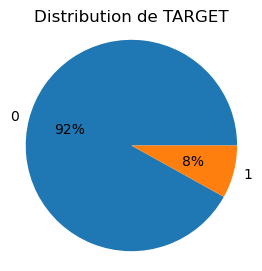

In [39]:
target_count.plot.pie(figsize = (3, 3), autopct = "%1.0f%%")
plt.axis("equal")
plt.ylabel("")
plt.title("Distribution de TARGET")
plt.show()

In [40]:
df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df["TARGET"], random_state = 42)

print("Jeu d'entraînement :", df_train.shape)
print("Jeu de validation :", df_test.shape)

Jeu d'entraînement : (246005, 772)
Jeu de validation : (61502, 772)


In [41]:
with timer("Temps d'enregistrement") :
    df_train.to_csv("csv/preprocessed/app_train.csv", index = False)
    df_test.to_csv("csv/preprocessed/app_test.csv", index = False)

Temps d'enregistrement : 101.038 seconde(s)


In [42]:
def preprocessing(input_dir, output_dir) :
    
    print("Prétraitement en cours...")
    
    input_files = ["application_train.csv", "bureau.csv", "bureau_balance.csv",
                   "credit_card_balance.csv", "installments_payments.csv",
                   "POS_CASH_balance.csv", "previous_application.csv"]

    with timer("Chargement des données") :
        for file in input_files :
            globals()[file[:-4].lower()] = pd.read_csv(os.path.join(input_dir, file))
    
    with timer("Traitement de credit_card_balance") :
        credit_card_balance_processed = process_credit_card_balance(credit_card_balance)

    with timer("Traitement de installments_payments") :
        installments_payments_processed = process_installments_payments(installments_payments)

    with timer("Traitement de pos_cash_balance") :
        pos_cash_balance_processed = process_pos_cash_balance(pos_cash_balance)
    
    with timer("Traitement de previous_application") :
        previous_application_processed = process_previous_application(previous_application)

    with timer("Traitement de bureau_balance") :
        bureau_balance_processed, bb_onehot_columns = process_bureau_balance(bureau_balance)

    with timer("Traitement de bureau") :
        bureau_processed = process_bureau(bureau, bureau_balance, bb_onehot_columns)

    with timer("Traitement de application_train") :
        application_train_processed = process_application_train(application_train)

    with timer("Jointures sur application_train") :
        df = application_train_processed.join(bureau_processed, how = "left", on = "SK_ID_CURR")
        df = df.join(previous_application_processed, how = "left", on = "SK_ID_CURR")
        df = df.join(pos_cash_balance_processed, how = "left", on = "SK_ID_CURR")
        df = df.join(installments_payments_processed, how = "left", on = "SK_ID_CURR")
        df = df.join(credit_card_balance_processed, how = "left", on = "SK_ID_CURR")

    with timer("Enregistrement des données") :
        df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df["TARGET"], random_state = 42)
        df_train.to_csv(os.path.join(output_dir, "app_train.csv"), index = False)
        df_test.to_csv(os.path.join(output_dir, "app_test.csv"), index = False)
    
    print("Dimensions du jeu d'entraînement :", df_train.shape)
    print("Dimensions du jeu de validation :", df_test.shape)
    print("Prétraitement terminé !")
    
    return df_train, df_test

In [43]:
df_train, df_test = preprocessing(input_dir = "csv", output_dir = "csv/preprocessed")

Prétraitement en cours...
Chargement des données : 31.481 seconde(s)
Traitement de credit_card_balance : 12.35 seconde(s)
Traitement de installments_payments : 19.448 seconde(s)
Traitement de pos_cash_balance : 9.597 seconde(s)
Traitement de previous_application : 26.58 seconde(s)
Traitement de bureau_balance : 4.954 seconde(s)
Traitement de bureau : 13.314 seconde(s)
Traitement de application_train : 3.505 seconde(s)
Jointures sur application_train : 2.905 seconde(s)
Enregistrement des données : 104.236 seconde(s)
Dimensions du jeu d'entraînement : (246005, 772)
Dimensions du jeu de validation : (61502, 772)
Prétraitement terminé !
